In [1]:
pip install tensorflow numpy pandas matplotlib pdf2image pillow pytesseract scikit-learn

Training data samples: 100
label
1    50
0    50
Name: count, dtype: int64
Training model...
Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.6274 - loss: 0.6090 - val_accuracy: 0.4000 - val_loss: 0.8056
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 499ms/step - accuracy: 0.5081 - loss: 0.7208 - val_accuracy: 1.0000 - val_loss: 0.3968
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 491ms/step - accuracy: 0.8544 - loss: 0.4375 - val_accuracy: 1.0000 - val_loss: 0.3711
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 651ms/step - accuracy: 0.9258 - loss: 0.3712 - val_accuracy: 1.0000 - val_loss: 0.2678
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 691ms/step - accuracy: 0.9769 - loss: 0.2941 - val_accuracy: 1.0000 - val_loss: 0.2262
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 453ms/step - accuracy: 0.9734 - loss: 0.2544 - val_accuracy: 1.0000 - val_loss: 0.1708
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 407ms/step - accuracy: 1.0000 - loss: 0.1778 - val_accuracy: 1.0000 - val_loss: 0.1375
Epoch 8/10
10

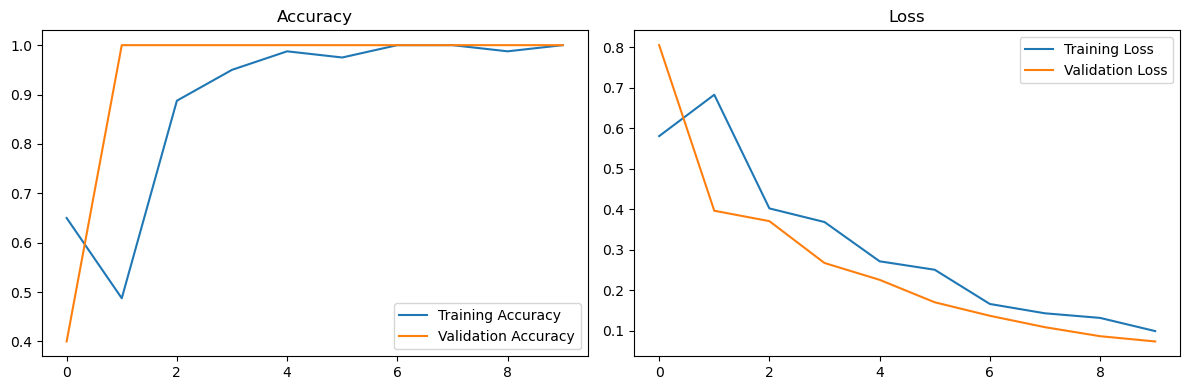

Evaluating model...
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 347ms/step - accuracy: 1.0000 - loss: 0.0746


Validation Accuracy: 1.0000
Model saved as 'bank_statement_detector.h5'
Processing: C:\Users\HP\Desktop\Bank Project\Balraj\Business Bank statment.pdf
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step

BANK STATEMENT ANALYSIS RESULTS

File: C:\Users\HP\Desktop\Bank Project\Balraj\Business Bank statment.pdf
Pages: 1
Bank Statement Pages: 1 of 1
Keywords Found: deposit, description, charges, account, balance, date, credit
Classification: BANK STATEMENT

Page Probabilities:
  Page 1: 99.87% probability

Text Analysis (partial):
# BARCLAYS

THE DIRECTOR
152-160 CITY ROAD
LONDON

UNITED KINGDOM
EC1V 2NX

Your Business Current Account

Date Description Money out £

Money in £

Balance £

7Jun — Start Balance

23,207.69

10Jun CO

On-Line Banking Bill Payment to 2,000.00
Vinita Nagare
Ref: Link Commu

21,207.69

11Jun

Card Payment to Royal Mail 506.00
Redirec On 10 Jun

20,701.69

ADVICE CONSULTANT LTD

Sort Code 20-53-33
Account No 03974790

SWIFTBIC BUKBGB22
IBAN GB91 BUKB 2053 3303 9747 90

Issued on 0

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from pdf2image import convert_from_path
from PIL import Image
import pytesseract
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import random

# Set Tesseract path if needed (uncomment for Windows)
# pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# Create directories for training data
os.makedirs('training_data/bank_statements', exist_ok=True)
os.makedirs('training_data/non_bank_statements', exist_ok=True)

# Sample function to create training data - in real use, you'd have your own dataset
def create_sample_training_data(num_samples=20):
    """Create sample training data (in a real scenario, use your own dataset)"""
    # Create sample bank statements
    for i in range(num_samples):
        # Create a sample image with bank statement-like content
        img = Image.new('RGB', (800, 600), color=(255, 255, 255))
        
        # Add bank statement-like text
        from PIL import ImageDraw, ImageFont
        draw = ImageDraw.Draw(img)
        try:
            font = ImageFont.truetype("arial.ttf", 20)
        except:
            font = ImageFont.load_default()
        
        draw.text((50, 50), "BANK STATEMENT", (0, 0, 0), font=font)
        draw.text((50, 100), f"Account Number: {random.randint(10000000, 99999999)}", (0, 0, 0), font=font)
        draw.text((50, 150), "Date Description Amount", (0, 0, 0), font=font)
        for j in range(5):
            draw.text((50, 200 + j*30), 
                      f"2023-{random.randint(1,12):02d}-{random.randint(1,28):02d} Transaction {j+1} ${random.uniform(10, 500):.2f}", 
                      (0, 0, 0), font=font)
        draw.text((50, 400), f"Opening Balance: ${random.uniform(1000, 5000):.2f}", (0, 0, 0), font=font)
        draw.text((50, 450), f"Closing Balance: ${random.uniform(1000, 5000):.2f}", (0, 0, 0), font=font)
        
        img.save(f'training_data/bank_statements/sample_{i}.png')
    
    # Create sample non-bank statements (invoices, receipts, etc.)
    for i in range(num_samples):
        img = Image.new('RGB', (800, 600), color=(255, 255, 255))
        draw = ImageDraw.Draw(img)
        
        doc_type = random.choice(['INVOICE', 'RECEIPT', 'CONTRACT'])
        draw.text((50, 50), doc_type, (0, 0, 0), font=font)
        draw.text((50, 100), f"{doc_type} Number: {random.randint(1000, 9999)}", (0, 0, 0), font=font)
        draw.text((50, 150), f"Date: 2023-{random.randint(1,12):02d}-{random.randint(1,28):02d}", (0, 0, 0), font=font)
        draw.text((50, 200), f"Customer: Customer {random.randint(1, 100)}", (0, 0, 0), font=font)
        for j in range(3):
            draw.text((50, 250 + j*30), 
                      f"Item {j+1}: Product {j+1} - ${random.uniform(10, 200):.2f}", 
                      (0, 0, 0), font=font)
        draw.text((50, 350), f"Total: ${random.uniform(50, 600):.2f}", (0, 0, 0), font=font)
        draw.text((50, 400), "Thank you for your business!", (0, 0, 0), font=font)
        
        img.save(f'training_data/non_bank_statements/sample_{i}.png')

# Create sample data if training data doesn't exist
if not os.listdir('training_data/bank_statements') or not os.listdir('training_data/non_bank_statements'):
    print("Creating sample training data...")
    create_sample_training_data(50)

# Create a DataFrame of training data
def create_training_dataframe():
    """Create a DataFrame with image paths and labels"""
    data = []
    for label in ['bank_statements', 'non_bank_statements']:
        for file in os.listdir(f'training_data/{label}'):
            data.append({
                'filepath': f'training_data/{label}/{file}',
                'label': 1 if label == 'bank_statements' else 0
            })
    return pd.DataFrame(data)

# Create and display training data
train_df = create_training_dataframe()
print(f"Training data samples: {len(train_df)}")
print(train_df['label'].value_counts())

# Split data into training and validation sets
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)

# Image preprocessing
def preprocess_image(image_path, target_size=(224, 224)):
    """Load and preprocess image for model input"""
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, target_size)
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return img

# Create TensorFlow datasets
def create_dataset(df, batch_size=8):
    """Create TensorFlow dataset from DataFrame"""
    file_paths = df['filepath'].values
    labels = df['label'].values
    
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(lambda x, y: (preprocess_image(x), y), 
                         num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = create_dataset(train_data)
val_dataset = create_dataset(val_data)

# Create the deep learning model
def create_model(input_shape=(224, 224, 3)):
    """Create a deep learning model for document classification"""
    base_model = EfficientNetB0(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    
    # Freeze the base model
    base_model.trainable = False
    
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs, outputs)
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create and train the model
model = create_model()

print("Training model...")
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    verbose=1
)

# Plot training history
def plot_training_history(history):
    """Plot training and validation accuracy and loss"""
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

plot_training_history(history)

# Evaluate the model
print("Evaluating model...")
val_loss, val_acc = model.evaluate(val_dataset)
print(f"Validation Accuracy: {val_acc:.4f}")

# Save the trained model
model.save('bank_statement_detector.h5')
print("Model saved as 'bank_statement_detector.h5'")

# Document processing functions
def convert_pdf_to_images(pdf_path, output_folder='temp_images'):
    """Convert PDF to a series of images"""
    os.makedirs(output_folder, exist_ok=True)
    images = convert_from_path(pdf_path, output_folder=output_folder)
    image_paths = []
    for i, image in enumerate(images):
        image_path = os.path.join(output_folder, f'page_{i+1}.jpg')
        image.save(image_path, 'JPEG')
        image_paths.append(image_path)
    return image_paths

def preprocess_for_model(image_path, target_size=(224, 224)):
    """Preprocess image for model prediction"""
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, target_size)
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return img.numpy()

def predict_document_type(model, image_path):
    """Predict if an image is a bank statement"""
    # Preprocess image
    img = preprocess_for_model(image_path)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    
    # Make prediction
    prediction = model.predict(img)
    return prediction[0][0]  # Return probability

def analyze_pdf_with_ocr(pdf_path):
    """Full analysis of a PDF file (bank statement or not)"""
    # Convert PDF to images
    image_paths = convert_pdf_to_images(pdf_path)
    
    # Initialize results
    results = {
        'file_path': pdf_path,
        'total_pages': len(image_paths),
        'bank_statement_pages': 0,
        'bank_statement_probabilities': [],
        'is_bank_statement': False,
        'text_analysis': "",
        'keywords_found': []
    }
    
    # Bank statement keywords
    keywords = {
        'statement', 'account', 'transaction', 'balance', 'date',
        'description', 'amount', 'deposit', 'withdrawal', 'debit',
        'credit', 'account number', 'available balance', 'current balance',
        'account summary', 'transactions', 'payments', 'charges'
    }
    
    # Process each page
    all_text = ""
    for img_path in image_paths:
        # Deep learning prediction
        prob = predict_document_type(model, img_path)
        results['bank_statement_probabilities'].append(prob)
        
        if prob > 0.5:
            results['bank_statement_pages'] += 1
        
        # OCR text extraction
        text = pytesseract.image_to_string(Image.open(img_path))
        all_text += text + "\n\n"
        
        # Clean up temporary image
        os.remove(img_path)
    
    # Remove temporary folder
    if os.path.exists('temp_images'):
        shutil.rmtree('temp_images')
    
    # Text-based analysis
    text_lower = all_text.lower()
    found_keywords = [kw for kw in keywords if kw in text_lower]
    results['keywords_found'] = found_keywords
    
    # Combine deep learning and text-based results
    results['text_analysis'] = all_text[:500] + "..." if len(all_text) > 500 else all_text
    
    # Final determination
    if results['bank_statement_pages'] > results['total_pages'] * 0.5 and len(found_keywords) >= 3:
        results['is_bank_statement'] = True
    
    return results

# Main function to process PDF files
def process_pdf_files(pdf_paths):
    """Process multiple PDF files and return results"""
    results = []
    for pdf_path in pdf_paths:
        if not os.path.isfile(pdf_path):
            print(f"File not found: {pdf_path}")
            results.append({
                'file_path': pdf_path,
                'error': 'File not found'
            })
            continue
        
        print(f"Processing: {pdf_path}")
        result = analyze_pdf_with_ocr(pdf_path)
        results.append(result)
    
    return results

# Display results in a formatted way
def display_results(results):
    """Display analysis results in a formatted way"""
    print("\n" + "="*70)
    print("BANK STATEMENT ANALYSIS RESULTS")
    print("="*70)
    
    for result in results:
        print(f"\nFile: {result['file_path']}")
        print(f"Pages: {result['total_pages']}")
        
        if 'error' in result:
            print(f"Error: {result['error']}")
            continue
        
        print(f"Bank Statement Pages: {result['bank_statement_pages']} of {result['total_pages']}")
        print(f"Keywords Found: {', '.join(result['keywords_found'])}")
        print(f"Classification: {'BANK STATEMENT' if result['is_bank_statement'] else 'NOT A BANK STATEMENT'}")
        
        print("\nPage Probabilities:")
        for i, prob in enumerate(result['bank_statement_probabilities']):
            print(f"  Page {i+1}: {prob:.2%} probability")
        
        print("\nText Analysis (partial):")
        print(result['text_analysis'])
        print("-"*70)

# Example usage
if __name__ == "__main__":
    # Replace these paths with your actual PDF files
    pdf_files_to_process = [
        r"C:\Users\HP\Desktop\Bank Project\Balraj\Business Bank statment.pdf",
    ]
    
    # Process all PDF files
    analysis_results = process_pdf_files(pdf_files_to_process)
    
    # Display results
    display_results(analysis_results)

In [3]:
import os
import re
from pdf2image import convert_from_path
from PIL import Image
import pytesseract
from bs4 import BeautifulSoup
import pandas as pd
from tabulate import tabulate
import shutil

# Uncomment and set the Tesseract path if needed (e.g., for Windows)
# pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

def convert_pdf_to_images(pdf_path, output_folder='temp_images'):
    """Convert PDF pages to images."""
    os.makedirs(output_folder, exist_ok=True)
    images = convert_from_path(pdf_path)
    image_paths = []
    for i, image in enumerate(images):
        image_path = os.path.join(output_folder, f'page_{i+1}.jpg')
        image.save(image_path, 'JPEG')
        image_paths.append(image_path)
    return image_paths

def ocr_image(image_path):
    """Perform OCR on an image and return hOCR output."""
    hocr = pytesseract.image_to_pdf_or_hocr(image_path, extension='hocr', config='--psm 6')
    return hocr

def parse_hocr(hocr):
    """Parse hOCR output to extract headers and data rows."""
    soup = BeautifulSoup(hocr, 'html.parser')
    words = []
    for span in soup.find_all('span', class_='ocrx_word'):
        text = span.get_text().strip()
        title = span['title']
        bbox_match = re.search(r'bbox (\d+) (\d+) (\d+) (\d+)', title)
        if bbox_match:
            x_min, y_min, x_max, y_max = map(int, bbox_match.groups())
            words.append({'text': text, 'x_min': x_min, 'y_min': y_min, 'x_max': x_max, 'y_max': y_max})

    # Sort words by y_min, then x_min to group into lines
    words.sort(key=lambda w: (w['y_min'], w['x_min']))

    # Group words into lines based on vertical proximity
    lines = []
    current_line = []
    prev_y = None
    line_threshold = 10  # Pixels to determine if words are on the same line
    for word in words:
        if prev_y is None or word['y_min'] - prev_y < line_threshold:
            current_line.append(word)
        else:
            lines.append(current_line)
            current_line = [word]
        prev_y = word['y_min']
    if current_line:
        lines.append(current_line)

    # Identify header line using common bank statement keywords
    header_keywords = ['date', 'description', 'details', 'particulars', 'amount', 'debit', 'credit', 'withdrawal', 'deposit', 'balance']
    header_line = None
    for line in lines:
        line_text = ' '.join(w['text'].lower() for w in line)
        if sum(kw in line_text for kw in header_keywords) >= 2:  # At least 2 keywords to confirm header
            header_line = line
            break

    if not header_line:
        print("No header line found.")
        return None, []

    # Extract headers and their positions
    headers = [{'text': word['text'], 'x_min': word['x_min'], 'x_max': word['x_max']} for word in header_line]
    headers.sort(key=lambda h: h['x_min'])
    column_boundaries = [(h['x_min'], h['x_max']) for h in headers]

    # Extract data rows
    data_rows = []
    for line in lines[lines.index(header_line) + 1:]:
        row = {h['text']: '' for h in headers}
        for word in line:
            for i, (col_x_min, col_x_max) in enumerate(column_boundaries):
                if col_x_min <= word['x_min'] <= col_x_max:
                    header_text = headers[i]['text']
                    row[header_text] += word['text'] + ' '
                    break
        for key in row:
            row[key] = row[key].strip()
        data_rows.append(row)

    return [h['text'] for h in headers], data_rows

def clean_data(data_rows, headers):
    """Clean the extracted data for consistent formatting."""
    cleaned_data = []
    for row in data_rows:
        cleaned_row = {}
        for header in headers:
            value = row.get(header, '')
            if 'date' in header.lower():
                try:
                    date_obj = pd.to_datetime(value)
                    cleaned_row[header] = date_obj.strftime('%Y-%m-%d')
                except:
                    cleaned_row[header] = value
            elif any(kw in header.lower() for kw in ['Date', 'Description', 'Money Out', 'Money In', 'Balance']):
                amount_str = re.sub(r'[^\d.-]', '', value)  # Remove non-numeric chars except . and -
                try:
                    cleaned_row[header] = float(amount_str)
                except ValueError:
                    cleaned_row[header] = value
            else:
                cleaned_row[header] = value
        cleaned_data.append(cleaned_row)
    return cleaned_data

def extract_account_info(text):
    """Extract account information from the text."""
    account_info = {}
    acc_match = re.search(r'account\s*[:#]?\s*([xX\d\s\-]+)', text, re.IGNORECASE)
    if acc_match:
        account_info["Account Number"] = acc_match.group(1).strip()
    name_match = re.search(r'(?:account holder|name)\s*[:]?\s*([A-Za-z\s]+)', text, re.IGNORECASE)
    if name_match:
        account_info["Account Holder"] = name_match.group(1).strip()
    period_match = re.search(r'statement\s*period\s*[:]?\s*(\d{1,2}[-\s]\w+[-\s]\d{4})\s*to\s*(\d{1,2}[-\s]\w+[-\s]\d{4})', text, re.IGNORECASE)
    if period_match:
        account_info["Start Date"] = period_match.group(1).strip()
        account_info["End Date"] = period_match.group(2).strip()
    opening_match = re.search(r'opening\s*balance\s*[:]?\s*([$\d,.]+)', text, re.IGNORECASE)
    if opening_match:
        account_info["Opening Balance"] = float(opening_match.group(1).replace('$', '').replace(',', ''))
    closing_match = re.search(r'(?:closing|closing available)\s*balance\s*[:]?\s*([$\d,.]+)', text, re.IGNORECASE)
    if closing_match:
        account_info["Closing Balance"] = float(closing_match.group(1).replace('$', '').replace(',', ''))
    return account_info

def analyze_pdf(pdf_path):
    """Analyze the PDF and extract transaction data into a table."""
    image_paths = convert_pdf_to_images(pdf_path)
    all_text = ""
    all_data_rows = []
    headers = None

    for img_path in image_paths:
        hocr = ocr_image(img_path)
        page_text = pytesseract.image_to_string(Image.open(img_path))  # For account info
        all_text += page_text + "\n\n"
        page_headers, page_data_rows = parse_hocr(hocr)
        if headers is None and page_headers:
            headers = page_headers
        if page_data_rows:
            all_data_rows.extend(page_data_rows)
        os.remove(img_path)

    if os.path.exists('temp_images'):
        shutil.rmtree('temp_images')

    account_info = extract_account_info(all_text)
    if not headers or not all_data_rows:
        print("No transaction data extracted.")
        return {'account_info': account_info, 'transactions': None}

    cleaned_data = clean_data(all_data_rows, headers)
    df = pd.DataFrame(cleaned_data, columns=headers)
    return {'account_info': account_info, 'transactions': df}

def display_results(results):
    """Display the extracted data in a tabular format."""
    for result in results:
        print(f"\nFile: {result['file_path']}")
        if result['transactions'] is not None:
            print("Transaction Data:")
            print(tabulate(result['transactions'], headers=result['transactions'].columns, tablefmt='psql'))
            print(f"Total Transactions: {len(result['transactions'])}")
        else:
            print("No transaction data found.")
        if result['account_info']:
            print("\nAccount Information:")
            for key, value in result['account_info'].items():
                print(f"  {key}: {value}")

def process_pdf_files(pdf_paths):
    """Process multiple PDF files and return results."""
    results = []
    for pdf_path in pdf_paths:
        if not os.path.isfile(pdf_path):
            print(f"Error: File not found - {pdf_path}")
            results.append({'file_path': pdf_path, 'error': 'File not found'})
            continue
        print(f"Processing: {pdf_path}")
        result = analyze_pdf(pdf_path)
        results.append({'file_path': pdf_path, **result})
    return results

if __name__ == "__main__":
    # Replace with your PDF path
    pdf_files_to_process = [
        r"C:\Users\HP\Desktop\Bank Project\Balraj\Revoult Bank statement.pdf",
    ]
    analysis_results = process_pdf_files(pdf_files_to_process)
    display_results(analysis_results)

Processing: C:\Users\HP\Desktop\Bank Project\Balraj\Revoult Bank statement.pdf

File: C:\Users\HP\Desktop\Bank Project\Balraj\Revoult Bank statement.pdf
Transaction Data:
+----+---------------------------------+-----------------+---------------------------------+-------------------------+----------------------+--------------+-------+--------------+-------------+
|    | Date                            | Value           | Date                            | Description             | ==                   | Money        | Out   | Moneyin.     | Balance     |
|----+---------------------------------+-----------------+---------------------------------+-------------------------+----------------------+--------------+-------+--------------+-------------|
|  0 |                                 |                 |                                 |                         |                      |              |       |              |             |
|  1 | Jun B/F                         |             

In [4]:
#correct code
import os
import re
from pdf2image import convert_from_path
from PIL import Image
import pytesseract
from bs4 import BeautifulSoup
import pandas as pd
from tabulate import tabulate
import shutil

def convert_pdf_to_images(pdf_path, output_folder='temp_images'):
    """Convert PDF pages to images."""
    os.makedirs(output_folder, exist_ok=True)
    images = convert_from_path(pdf_path)
    image_paths = []
    for i, image in enumerate(images):
        image_path = os.path.join(output_folder, f'page_{i+1}.jpg')
        image.save(image_path, 'JPEG')
        image_paths.append(image_path)
    return image_paths

def ocr_image(image_path):
    """Perform OCR on an image and return hOCR output."""
    hocr = pytesseract.image_to_pdf_or_hocr(image_path, extension='hocr', config='--psm 6')
    return hocr

def parse_hocr(hocr):
    """Parse hOCR output to extract headers and data rows."""
    soup = BeautifulSoup(hocr, 'html.parser')
    words = []
    for span in soup.find_all('span', class_='ocrx_word'):
        text = span.get_text().strip()
        title = span['title']
        bbox_match = re.search(r'bbox (\d+) (\d+) (\d+) (\d+)', title)
        if bbox_match:
            x_min, y_min, x_max, y_max = map(int, bbox_match.groups())
            words.append({'text': text, 'x_min': x_min, 'y_min': y_min, 'x_max': x_max, 'y_max': y_max})

    # Sort words by y_min, then x_min to group into lines
    words.sort(key=lambda w: (w['y_min'], w['x_min']))

    # Group words into lines based on vertical proximity
    lines = []
    current_line = []
    prev_y = None
    line_threshold = 15  # Adjusted threshold for better line grouping
    for word in words:
        if prev_y is None or abs(word['y_min'] - prev_y) < line_threshold:
            current_line.append(word)
        else:
            lines.append(current_line)
            current_line = [word]
        prev_y = word['y_min']
    if current_line:
        lines.append(current_line)

    # Identify header line using common bank statement keywords
    header_keywords = ['date', 'description', 'details', 'amount', 'debit', 'credit', 'balance']
    header_line = None
    for line in lines:
        line_text = ' '.join(w['text'].lower() for w in line)
        if sum(kw in line_text for kw in header_keywords) >= 2:
            header_line = line
            break

    if not header_line:
        print("No header line detected.")
        return None, []

    # Extract headers and their positions
    headers = [{'text': word['text'], 'x_min': word['x_min'], 'x_max': word['x_max']} for word in header_line]
    headers.sort(key=lambda h: h['x_min'])
    column_boundaries = [(h['x_min'], h['x_max']) for h in headers]

    # Extract data rows
    data_rows = []
    for line in lines[lines.index(header_line) + 1:]:
        row = {h['text']: '' for h in headers}
        for word in line:
            for i, (col_x_min, col_x_max) in enumerate(column_boundaries):
                if col_x_min <= word['x_min'] <= col_x_max or (word['x_min'] < col_x_min and word['x_max'] > col_x_max):
                    header_text = headers[i]['text']
                    row[header_text] += word['text'] + ' '
                    break
        for key in row:
            row[key] = row[key].strip()
        if any(row.values()):  # Only add non-empty rows
            data_rows.append(row)

    return [h['text'] for h in headers], data_rows

def clean_data(data_rows, headers):
    """Clean the extracted data for consistent formatting."""
    cleaned_data = []
    for row in data_rows:
        cleaned_row = {}
        for header in headers:
            value = row.get(header, '')
            if 'date' in header.lower():
                try:
                    date_obj = pd.to_datetime(value, errors='coerce')
                    cleaned_row[header] = date_obj.strftime('%Y-%m-%d') if pd.notna(date_obj) else value
                except:
                    cleaned_row[header] = value
            elif any(kw in header.lower() for kw in ['amount', 'debit', 'credit', 'balance']):
                amount_str = re.sub(r'[^\d.-]', '', value)  # Keep digits, decimal, and negative signs
                try:
                    cleaned_row[header] = float(amount_str) if amount_str else value
                except ValueError:
                    cleaned_row[header] = value
            else:
                cleaned_row[header] = value
        cleaned_data.append(cleaned_row)
    return cleaned_data

def analyze_pdf(pdf_path):
    """Analyze the PDF and extract transaction data into a table."""
    image_paths = convert_pdf_to_images(pdf_path)
    all_data_rows = []
    headers = None

    for img_path in image_paths:
        hocr = ocr_image(img_path)
        page_headers, page_data_rows = parse_hocr(hocr)
        if headers is None and page_headers:
            headers = page_headers
        if page_data_rows:
            all_data_rows.extend(page_data_rows)
        os.remove(img_path)

    if os.path.exists('temp_images'):
        shutil.rmtree('temp_images')

    if not headers or not all_data_rows:
        print("No transaction data extracted.")
        return None

    cleaned_data = clean_data(all_data_rows, headers)
    df = pd.DataFrame(cleaned_data, columns=headers)
    return df

def display_table(df):
    """Display the DataFrame in a proper table format."""
    if df is not None:
        print(tabulate(df, headers=df.columns, tablefmt='psql', showindex=False))
        print(f"\nTotal Transactions: {len(df)}")
    else:
        print("No data to display.")

if __name__ == "__main__":
    # Replace with your PDF file path
    pdf_path = r"C:\Users\HP\Desktop\Bank Project\Balraj\Business Bank statment.pdf"
    if not os.path.isfile(pdf_path):
        print(f"Error: File not found - {pdf_path}")
    else:
        print(f"Processing: {pdf_path}")
        transaction_df = analyze_pdf(pdf_path)
        display_table(transaction_df)

Processing: C:\Users\HP\Desktop\Bank Project\Balraj\Business Bank statment.pdf
+----------------+--------------------------------+------------------------------+-----------+-----+------------------------------+------+-----+-----------+-----+----------------------------------+------------------+--------------+
| Date           | Description                    | Money                        | out       | £   | Money                        | in   | £   | Balance   | £   | Start                            | balance          | £23,207.69   |
|----------------+--------------------------------+------------------------------+-----------+-----+------------------------------+------+-----+-----------+-----+----------------------------------+------------------+--------------|
| 7Jun           | Balance                        |                              |           |     |                              |      |     | 23207.69  |     | Money                            | out              | £69,971.

In [5]:
# Install required libraries
!pip install pdf2image paddlepaddle paddleocr pandas numpy opencv-python
!sudo apt-get install poppler-utils

Sudo is disabled on this machine. To enable it, go to the ]8;;ms-settings:developers\Developer Settings page]8;;\ in the Settings app


In [6]:
import os
import re
import cv2
import numpy as np
import pandas as pd
from pdf2image import convert_from_path
from paddleocr import PaddleOCR

# Configuration
PDF_PATH = r"C:\Users\HP\Desktop\Bank Project\Balraj\Sales Invoices\Arul Paul Invoice-1.pdf"  # Replace with your PDF path
OUTPUT_CSV = "transactions.csv"
EXPECTED_HEADERS = ['date', 'description', 'amount', 'withdrawal', 'deposit', 'balance']
MIN_HEADER_MATCH = 3  # Minimum matching headers to validate table
DPI = 200  # PDF conversion quality

def preprocess_image(image):
    """Enhance scanned document quality"""
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)
    denoised = cv2.fastNlMeansDenoising(gray, h=10)
    return cv2.cvtColor(denoised, cv2.COLOR_GRAY2BGR)

def clean_text(text):
    """Normalize text for header matching"""
    return re.sub(r'[^a-zA-Z0-9]', '', str(text).lower())

def is_transaction_table(df):
    """Check if dataframe matches bank transaction table structure"""
    if len(df) < 1: 
        return False
    
    header_row = df.iloc[0].apply(clean_text).tolist()
    matches = 0
    
    for expected in EXPECTED_HEADERS:
        clean_expected = clean_text(expected)
        if any(clean_expected in cell for cell in header_row):
            matches += 1
            
    return matches >= MIN_HEADER_MATCH

def extract_valid_tables(img):
    """Process image and extract valid transaction tables"""
    ocr = PaddleOCR(use_angle_cls=True, lang='en')
    result = ocr.ocr(img)
    valid_tables = []
    
    # Find tables in OCR results
    for region in result:
        for line in region:
            if 'table' in line and line['type'] == 'table':
                try:
                    html_content = line['res']['html']
                    df = pd.read_html(html_content)[0]
                    
                    if is_transaction_table(df):
                        # Set first row as header
                        df.columns = df.iloc[0]
                        df = df[1:].reset_index(drop=True)
                        valid_tables.append(df)
                except:
                    continue
                    
    return valid_tables

# Main processing pipeline
def process_bank_statement(pdf_path):
    all_tables = []
    
    # Convert PDF to images
    # Make sure poppler_path points to the folder containing the 'bin' directory
    poppler_bin_path = r'C:\Users\HP\Desktop\Bank Project\poppler-24.08.0\Library\bin'  # Update this path if needed

    images = convert_from_path(
        pdf_path, 
        dpi=DPI,
        poppler_path=poppler_bin_path
    )
    
    print(f"Converted {len(images)} pages to images")
    
    # Process each page
    for i, image in enumerate(images):
        print(f"Processing page {i+1}...")
        preprocessed = preprocess_image(image)
        page_tables = extract_valid_tables(np.array(preprocessed))
        
        if page_tables:
            print(f"Found {len(page_tables)} transaction tables on page {i+1}")
            all_tables.extend(page_tables)
    
    # Combine all tables
    if all_tables:
        final_df = pd.concat(all_tables, ignore_index=True)
        print(f"Extracted {len(final_df)} transactions")
        return final_df
    else:
        print("No transaction tables found")
        return pd.DataFrame()

# Execute the pipeline
result_df = process_bank_statement(PDF_PATH)

# Save results
if not result_df.empty:
    result_df.to_csv(OUTPUT_CSV, index=False)
    print(f"Results saved to {OUTPUT_CSV}")
    print(result_df.head())
else:
    print("No transactions extracted")

Converted 1 pages to images
Processing page 1...


C:\Users\HP\AppData\Local\Temp\ipykernel_15636\1833500668.py:43: DeprecationWarning: The parameter `use_angle_cls` has been deprecated and will be removed in the future. Please use `use_textline_orientation` instead.
  ocr = PaddleOCR(use_angle_cls=True, lang='en')
j:\anaconda\Lib\site-packages\paddle\utils\cpp_extension\extension_utils.py:715: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Using official model (PP-LCNet_x1_0_doc_ori), the model files will be automatically downloaded and saved in C:\Users\HP\.paddlex\official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('UVDoc', None)
The model(UVDoc) is not supported to run in MKLDNN mode! Using `paddle` instead!
Using official model (UVDoc), the model files will be automatically downloaded and saved in C:\Users\HP\.paddlex\official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Using official model (PP-LCNet_x1_0_textline_ori), the model files will be automatically downloaded and saved in C:\Users\HP\.paddlex\official_models.
Creating model: ('PP-OCRv5_server_det', None)
Using official model (PP-OCRv5_server_det), the model files will be automatically downloaded and saved in C:\Users\HP\.paddlex\official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-OCRv5_server_rec', None)
Using official model (PP-OCRv5_server_rec), the model files will be automatically downloaded and saved in C:\Users\HP\.paddlex\official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\HP\AppData\Local\Temp\ipykernel_15636\1833500668.py:44: DeprecationWarning: Please use `predict` instead.
  result = ocr.ocr(img)


No transaction tables found
No transactions extracted
